In [1]:
import numpy as np
import pandas as pd
from scipy import sparse as ss
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder

## Read the dataframe

In [2]:
df = pd.read_csv('../data/CBLB/1M_CBLB_pairs.tsv', delimiter='\t')
df

,name_1,smiles_1,name_2,smiles_2,IFP,IFP_polar,reaction
0,EN300-1273273_i001,COc1cc(c(c(c1)Br)O)C(=O)[O-],EN300-80433_i001,c1ccc(c(c1)CBr)OC(F)F,0.333333,0.0,Negishi
1,EN300-35822484_i001,C1C(CC1(F)F)(CF)CBr,EN300-8688089_i001,c1cc(cc(c1)[C@@H]2CC[NH2+]C2)C#N,0.550000,0.0,Grignard_Nitrile
2,EN300-53744_i001,c1cc(ccc1CN)[NH+]2CCOCC2,EN300-310211_i001,Cc1nnc2n1C[C@@H]([N@@](C2)C)C(=O)[O-],0.500000,0.0,Amide
3,EN300-7437778_i001,C1CN(CC[NH2+]1)c2[nH]nc(n2)Br,EN300-1620610_i001,CC1(CC[C@@H](C1)CC(=O)[O-])C,0.450000,0.0,Amide
4,EN300-317553_i001,Cc1ccc(cc1CNC(=O)OC(C)(C)C)Br,EN300-249270_i001,CC(c1cccc(c1)C#N)(F)F,0.523810,0.2,Grignard_Nitrile
...,...,...,...,...,...,...,...
999995,EN300-201019_i001,COCC1(CCC1)C[NH3+],EN300-313500_i001,CC(C)n1cc(c(n1)C2CCOCC2)C(=O)[O-],0.000000,0.0,Amide
999996,EN300-25616_i002,Cc1ccc(cc1)[C@H](C2CC2)[NH3+],EN300-11663_i002,C[C@H](C(=O)c1ccc(cc1)NS(=O)(=O)C)Cl,0.000000,0.0,Reductive_Amination
999997,EN300-1707771_i001,CCn1cnnc1CCl,EN300-91321_i002,Cc1ccc(cc1)[N@@H+]2CCC[C@H](C2=O)Br,0.000000,0.0,Negishi
999998,EN300-14055_i001,c1ccc(cc1)CNC(=O)C2CC[NH2+]CC2,EN300-92028_i001,Cc1c(cn(n1)c2ccc(cc2)Cl)C(=O)[O-],0.000000,0.0,Amide


## Generate fingerprints

In [3]:
fp_gen = AllChem.GetMorganGenerator(radius=2, fpSize=2048, includeChirality=True, useBondTypes=True)

In [4]:
en = OneHotEncoder(sparse_output=True, dtype=np.int8)
en.fit(df[['reaction']])
reaction_features = en.transform(df[['reaction']])

In [5]:
#Generate fingerprints for every pair of reagents, convert to sparse matrix
row_idx = list()
col_idx = list()

for count, (smi_1, smi_2) in enumerate(tqdm(zip(df['smiles_1'], df['smiles_2']), desc='Generating fingerprints', unit='fp')):

    mol1, mol2 = Chem.MolFromSmiles(smi_1), Chem.MolFromSmiles(smi_2) 
    fp1, fp2 = fp_gen.GetFingerprint(mol1), fp_gen.GetFingerprint(mol2)

    fp_and = fp1 & fp2
    fp_xor = fp1 ^ fp2
    fp = fp_and + fp_xor

    onbits = list(fp.GetOnBits())
    #these bits all have the same row:
    row_idx += [count]*len(onbits)
    #and the column indices of those bits:
    col_idx+=onbits

#generate a sparse matrix out of the row,col indices:
fingerprint_matrix = ss.coo_matrix((np.ones(len(row_idx)).astype(bool), (row_idx, col_idx)), shape=(max(row_idx)+1, 4096))
#convert to csr matrix:
fingerprint_matrix =  ss.csr_matrix(fingerprint_matrix)

Generating fingerprints: 1000000fp [08:00, 2079.39fp/s]


In [6]:
fps = ss.hstack([fingerprint_matrix, reaction_features])
#Save fingerprints as sparse matrix
#ss.save_npz('../data/CBLB/1M_CBLB_fingerprints.npz', fingerprint_matrix)

## Generate training labels

In [7]:
#Set thresholds of IFP similarity
q = 0.6
q_polar = 0.25

In [8]:
#Create np array with training labels for each pair: hit - '1', else - '0'
y = np.where(((df['IFP'] >= q) & (df['IFP_polar']>=q_polar)), 1, 0)
#Save labels as np array
#np.save('../data/CBLB/1M_CBLB_labels.npy', y)

## PLots

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns

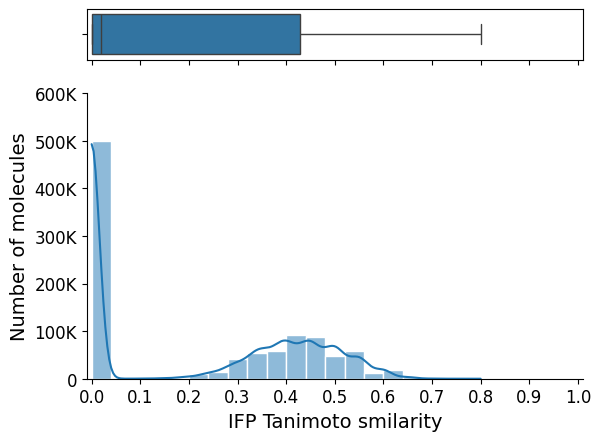

In [10]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.set(style="ticks")

sns.boxplot(data=df['IFP'], orient="h", fliersize=1, ax=ax_box)
plot = sns.histplot(data=df['IFP'], bins=20, kde=True, kde_kws={'bw_adjust':1.15}, ax=ax_hist)
plt.xlim([-0.01,1.01])
plt.yticks([0, 100000, 200000, 300000, 400000, 500000, 600000], ['0', '100K', '200K', '300K', '400K', '500K', '600K'], fontsize = 12)
plt.xticks([i*0.1 for i in range(11)], fontsize = 12)
ax_box.set(xlabel='')
plt.xlabel('IFP Tanimoto smilarity', fontsize=14)
plt.ylabel('Number of molecules', fontsize=14)
plot.spines['top'].set_visible(False)
plot.spines['right'].set_visible(False)
#plt.savefig(f'/projects/ML-SpaceDock/pictures/CACHE4_1M_ifp_destribution.png', dpi=300, bbox_inches='tight')
plt.show()

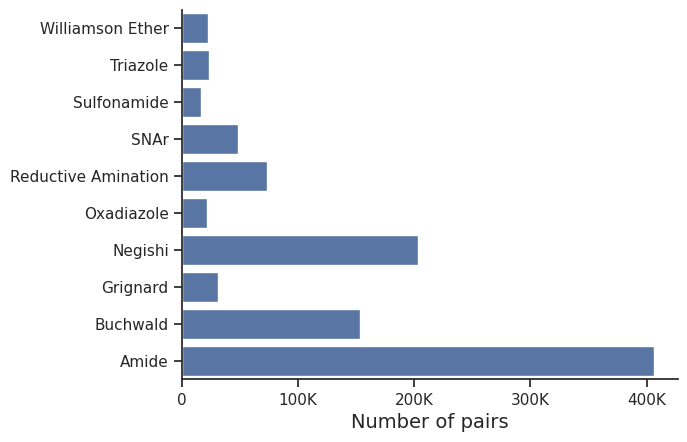

In [11]:
labels = ['Amide', 'Buchwald', 'Grignard', 'Negishi', 'Oxadiazole', 'Reductive Amination', 'SNAr', 'Sulfonamide', 'Triazole', 'Williamson Ether']
plot = sns.barplot(y=labels, 
            x=df.groupby('reaction').size(), 
            color='#4c72b0', 
            orient='h', 
            order=labels[::-1]
            )
plt.xticks(rotation = 0)
plt.xlabel('Number of pairs', loc='center', rotation=0, fontsize = 12)
plt.xticks(ticks = [0, 100000, 200000, 300000, 400000],labels=['0', '100K', '200K', '300K', '400K'])
plt.xlabel('Number of pairs', loc='center', rotation=0, fontsize = 14)
plot.spines['top'].set_visible(False)
plot.spines['right'].set_visible(False)
#plt.savefig(f'/projects/ML-SpaceDock/pictures/CACHE4_1M_pair_destribution_by_reaction.png', dpi=300, bbox_inches='tight')